In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
from sklearn.decomposition import PCA
import scipy

In [2]:
ph=1.5574E-4
times=[1,2,3,6,7,9,13,16,21,24,31] 
pxt=[(x) for x in list(range(3,50,1))]
neh=range(1,120)
# path="C:/Workplace/C++/d2ome_v2/v2/v2/bin/Debug/liverpool_liver_31_test/"

In [3]:
all_AAs=['a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'p','q', 'r', 's', 't', 'v', 'w', 'y']
def charcount(pepSeq):
    res={key: 0 for key in all_AAs}     
    for c in pepSeq.lower():
        if c.isalpha():
            res[c]+=1
    return res

In [4]:
def sort_pep(peptidesinfo,peptides):
    temp={p: peptidesinfo[p]["T_NEH"] for i,p in enumerate(peptides)}
    temp=dict(sorted(temp.items(), key=lambda item: item[1])) 
    return list(temp.keys()) 

In [5]:
def getPeptiedsInfo(protien,time):
    print(protien,time)
    peptides=[x.split(f'_{time}_')[0] for x in os.listdir(path) if (protien+".csv" in x) and (f"_{time}_" in x)]
    peptides=[x  for x in peptides if 'A' in x]
    peptidesinfo=dict()
    print(len(peptides))
    

    for k in range(len(peptides)): 
        data=pd.read_csv(f"{path}{peptides[k]}_{time}_{protien}.csv")
        data["pxt_neh"]=data.NEH*data.pxt
        data=data[["NEH","pxt","RMSE","pxt_neh","T_NEH","NH"]] 
        minval=min(data.RMSE)

        data=data[data.RMSE==minval]

        peptidesinfo[peptides[k]]={"pxt_neh":float(data.pxt_neh),"T_NEH":float(data.T_NEH),"Seq":peptides[k],
                               "charcount":charcount(peptides[k])}
           
    visited=set()
    visited.add(peptides[0].split('_')[1])
    coefficients=[]
    peptides=sort_pep(peptidesinfo,peptides)
    for k in range(0,len(peptides)-1):
        if(peptides[k+1].split('_')[1] in visited):
            continue

        pep1=peptidesinfo[peptides[k]]
        pep2=peptidesinfo[peptides[k+1]]    
        visited.add(peptides[k].split('_')[1])

        r=pep1["pxt_neh"]/pep2["pxt_neh"]
        coefficients.append([pep1["charcount"][c]-r*pep2["charcount"][c] for c in all_AAs])
        
    return peptides,peptidesinfo,all_AAs,np.array(coefficients)


In [6]:
def compute_result(peptides,peptidesinfo,all_AAs,sol):
    t_neh,e_neh=[],[]
    for i in range (len(peptides)):
        pep1=peptidesinfo[peptides[i]]
        p_neh=0
        for index,c in enumerate(all_AAs): 
            p_neh+=(pep1["charcount"][c]*sol[index]) 
        t_neh.append(pep1["T_NEH"])
        e_neh.append(p_neh)

    res=pd.DataFrame([peptides,t_neh,e_neh])
    res=res.transpose()
    res.columns=["peptides","True_NEH","e_NEH"]
    res["dif"]=abs(res.True_NEH-res.e_NEH)
#     print(np.mean(res.dif),np.median(res.dif),np.std(res.dif))
    return res.sort_values(by='dif')

In [7]:
e_vals=[]
for time in times[3:]:
    print(time,"===========================================")
    # time=9
    a_val=4
    # w_val=0.08
    # proteins=["CPSM_MOUSE","FAS_MOUSE","DHB4_MOUSE","ASSY_MOUSE","ATPA_MOUSE","ATPB_MOUSE","BHMT1_MOUSE",
    #          "CLH1_MOUSE","DHE3_MOUSE","DHSO_MOUSE","ECHA_MOUSE",
    #          "G3P_MOUSE","HMCS2_MOUSE","HYES_MOUSE","MYH9_MOUSE","PYC_MOUSE","PYGL_MOUSE","SAHH_MOUSE",
    #          "SARDH_MOUSE","SBP1_MOUSE","THIM_MOUSE","TKT_MOUSE"]
    # proteins=pd.read_csv("H:/Warehouse/Data/liverpool/liver/6_23_2022_c/"+"Analyzed_Proteins_and_Their_Rates.csv").Proteins.unique()

    path="C:/Workplace/C++/d2ome_v2/v2/v2/bin/Debug/second_r_heart/" 
    proteins=np.unique(["_".join(x.split('_')[4:]).replace('.csv','') for x in os.listdir(path) if ("_MOUSE.csv" in x)])

    coefficients=np.array([])
    _peptides,_peptidesinfo=[],[]
    for protine in proteins:
        try:
            peptides1,peptidesinfo1,all_AAs1,coefficients1=getPeptiedsInfo(protine,time) 
            print(protine,len(all_AAs1)==20)
            if(coefficients.shape[0]==0):
                coefficients=coefficients1
            else:
                coefficients=np.concatenate((coefficients1,coefficients), axis=0)
            _peptides.append(peptides1)
            _peptidesinfo.append(peptidesinfo1)
        except:
            continue

    # sol=list(scipy.optimize.nnls(coefficients[:,2 :],-a_val*coefficients[:,0]-w_val*coefficients[:,1])[0])
    sol=list(scipy.optimize.nnls(coefficients[:,1:],-a_val*coefficients[:,0])[0])
    # sol=list(scipy.optimize.nnls(coefficients[:,2:],-a_val*coefficients[:,0]-w_val*coefficients[:,1])[0])

    print("====>",len(sol))
    sol.insert(0,a_val) 
    # sol.insert(1,w_val) 
    print("\nValues\n","\n".join([all_AAs1[index]+"= "+str(x) for index,x in enumerate(sol)]))
    res=pd.DataFrame()
    for i in range(len(proteins)):
        res=pd.concat([res,compute_result(_peptides[i],_peptidesinfo[i],all_AAs1,sol)])

    print("\nstats",np.mean(res.dif),np.median(res.dif),np.std(res.dif))    
    
    e_vals.append(sol)
 

6 ===========================================
ACADV_MOUSE 6
8
ACADV_MOUSE True
ACTN2_MOUSE 6
14
ACTN2_MOUSE True
ALBU_MOUSE 6
18
ALBU_MOUSE True
AT1A1_MOUSE 6
8
AT1A1_MOUSE True
AT2A2_MOUSE 6
10
AT2A2_MOUSE True
ATPA_MOUSE 6
12
ATPA_MOUSE True
ATPB_MOUSE 6
9
ATPB_MOUSE True
DESM_MOUSE 6
9
DESM_MOUSE True
ECHA_MOUSE 6
8
ECHA_MOUSE True
GRP75_MOUSE 6
7
GRP75_MOUSE True
KPYM_MOUSE 6
8
KPYM_MOUSE True
MYG_MOUSE 6
15
MYG_MOUSE True
MYH6_MOUSE 6
58
MYH6_MOUSE True
MYOM1_MOUSE 6
5
MYOM1_MOUSE True
MYPC3_MOUSE 6
13
MYPC3_MOUSE True
ODO1_MOUSE 6
10
ODO1_MOUSE True
PYGB_MOUSE 6
11
PYGB_MOUSE True
SDHA_MOUSE 6
8
SDHA_MOUSE True
THIL_MOUSE 6
8
THIL_MOUSE True
TITIN_MOUSE 6
80
TITIN_MOUSE True
TNNT2_MOUSE 6
7
TNNT2_MOUSE True
TPIS_MOUSE 6
8
TPIS_MOUSE True
TPM1_MOUSE 6
11
TPM1_MOUSE True
====> 19

Values
 a= 4
c= 1.369451384852524
d= 0.7339523713627886
e= 0.8189447038919506
f= 0.2868725574417118
g= 0.0
h= 0.773915145120114
i= 0.062456757833711136
k= 0.0
l= 0.0078023564135933365
m= 0.178807971845016

TPIS_MOUSE True
TPM1_MOUSE 24
11
TPM1_MOUSE True
====> 19

Values
 a= 4
c= 1.6610459246397498
d= 2.440769391703759
e= 3.355305643397693
f= 0.8992807933117826
g= 0.6381065642476078
h= 1.7522677093575612
i= 0.6467930310040672
k= 0.0
l= 0.5715344283461681
m= 0.8822019179553777
n= 0.9884736993341942
p= 1.0484030533807598
q= 3.4973346317478713
r= 0.8170140081926731
s= 1.1094294352748018
t= 0.10601506784605698
v= 0.8974418262885497
w= 0.28297972255641596
y= 0.47866119081050895

stats 6.390221843307024 6.428733696561565 2.606216459504094
31 ===========================================
ACADV_MOUSE 31
8
ACADV_MOUSE True
ACTN2_MOUSE 31
14
ACTN2_MOUSE True
ALBU_MOUSE 31
18
ALBU_MOUSE True
AT1A1_MOUSE 31
8
AT1A1_MOUSE True
AT2A2_MOUSE 31
10
AT2A2_MOUSE True
ATPA_MOUSE 31
12
ATPA_MOUSE True
ATPB_MOUSE 31
9
ATPB_MOUSE True
DESM_MOUSE 31
9
DESM_MOUSE True
ECHA_MOUSE 31
8
ECHA_MOUSE True
GRP75_MOUSE 31
7
GRP75_MOUSE True
KPYM_MOUSE 31
8
KPYM_MOUSE True
MYG_MOUSE 31
15
MYG_MOUSE True
MYH6_MOUSE 31
58
MY

In [8]:
evals2=np.array(e_vals)
trueval=[4.0,1.62,1.89,3.95,0.32,2.06,2.88,1.0,0.6,0.54,1.12,1.89,2.59,3.95,3.43,2.61,0.2,0.56,0.08,0.42]

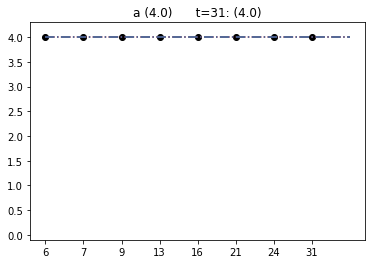

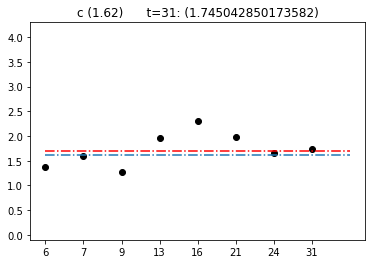

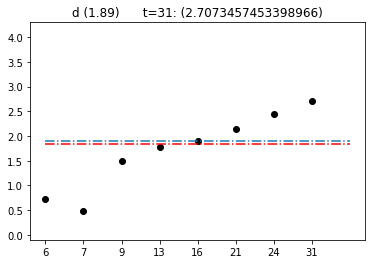

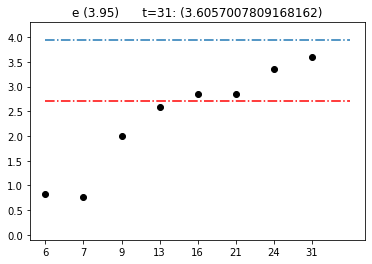

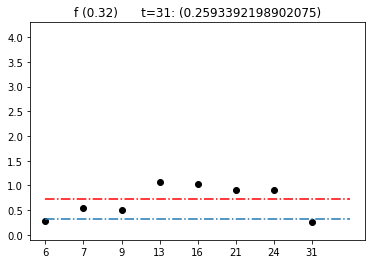

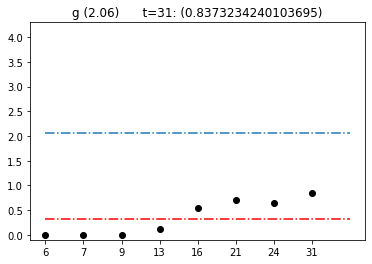

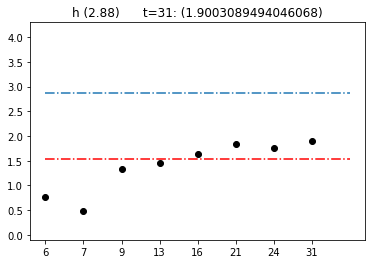

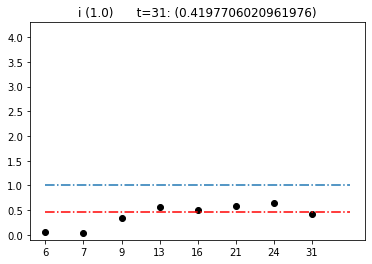

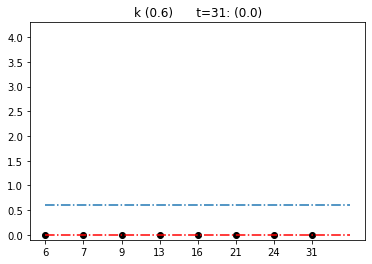

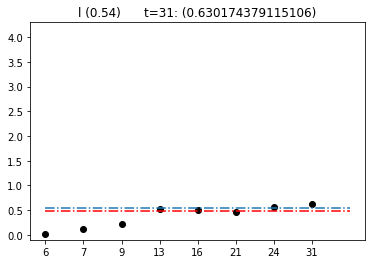

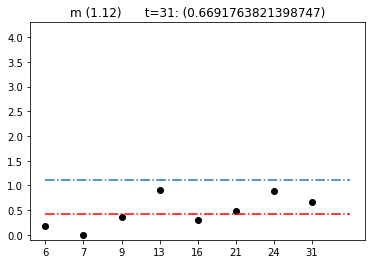

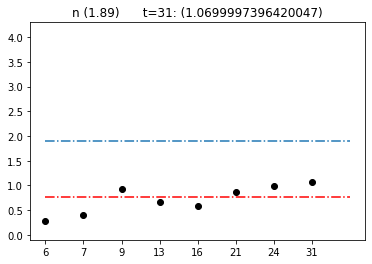

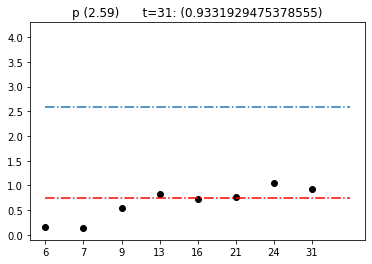

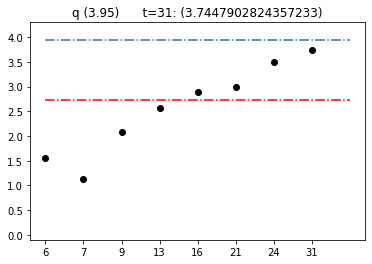

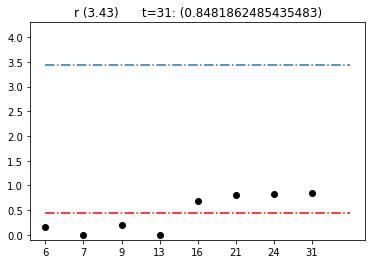

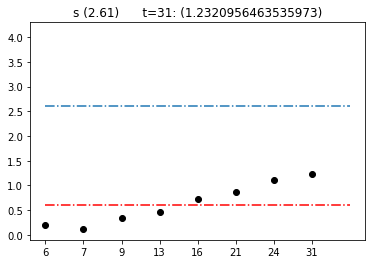

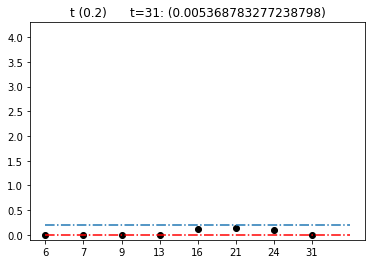

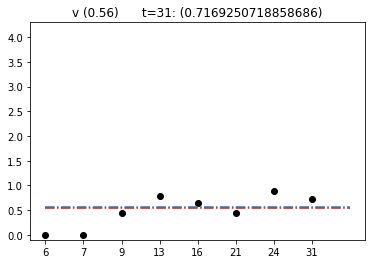

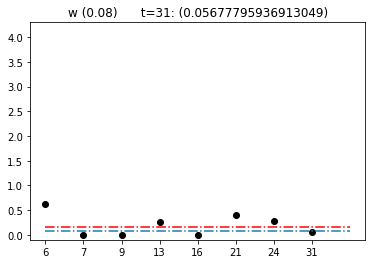

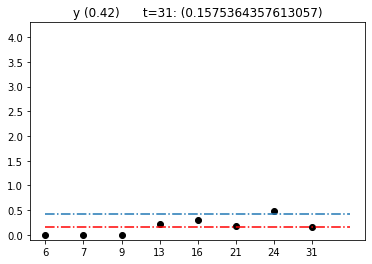

In [9]:
for i in range(len(all_AAs1)):
    plt.scatter(range(8),evals2[:,i],c='k')
    plt.xticks(np.arange(8), times[3:])
    plt.title(all_AAs1[i]+f" ({trueval[i]})"+f"      t=31: ({evals2[:,i][-1]})")
    plt.ylim([-0.1,4.3])
    plt.hlines(y=np.median(evals2[:,i]),xmin=0,xmax=8,linestyle="-.",color='r')
    plt.hlines(y=trueval[i],xmin=0,xmax=8,linestyle="-.")
    plt.show()
    

In [10]:
print("\nValues\n","\n".join([all_AAs1[index]+"= "+str(x) for index,x in enumerate(sol)]))


Values
 a= 4
c= 1.745042850173582
d= 2.7073457453398966
e= 3.6057007809168162
f= 0.2593392198902075
g= 0.8373234240103695
h= 1.9003089494046068
i= 0.4197706020961976
k= 0.0
l= 0.630174379115106
m= 0.6691763821398747
n= 1.0699997396420047
p= 0.9331929475378555
q= 3.7447902824357233
r= 0.8481862485435483
s= 1.2320956463535973
t= 0.005368783277238798
v= 0.7169250718858686
w= 0.05677795936913049
y= 0.1575364357613057


In [11]:
print("proteins",len(proteins),"peptides",res.shape[0])

proteins 23 peptides 345


In [12]:
res=res.sort_values(by='dif')
res.head(20)

,peptides,True_NEH,e_NEH,dif
11,_TcVADESAANcDK_2,28.0,27.534867,0.465133
19,_IEDEQALALQLQK_2,32.0,31.463412,0.536588
20,_IEDEQALALQLQK_3,32.0,31.463412,0.536588
44,_LQDAEEAVEAVNAK_3,37.0,36.403263,0.596737
43,_LQDAEEAVEAVNAK_2,37.0,36.403263,0.596737
5,_DAVLNAWAEDVDLR_2,29.0,28.396901,0.603099
1,_LTVELADPDAEVK_2,25.0,24.258854,0.741146
0,_LVDEAFQDLMTEVcK_3,25.0,25.744009,0.744009
4,_SIDDLEDELYAQK_2,27.0,26.147981,0.852019
5,_SIDDLEDELYAQK_3,27.0,26.147981,0.852019


In [13]:
res.tail(20)

,peptides,True_NEH,e_NEH,dif
0,_NTGIIcTIGPASR_2,23.0,12.773214,10.226786
6,_DAEEGPVEDTKPKPSR_3,37.0,26.671272,10.328728
73,_DSGYYSLTAENSSGSDTQK_2,37.0,26.626292,10.373708
62,_VPAPAEVPVTPPTLVSGLK_2,33.0,22.479871,10.520129
3,_VNIHGGAVSLGHPIGM_3,29.0,17.957942,11.042058
4,_PSDLAGPVVAETRPGTK_3,34.0,22.942316,11.057684
6,_TPIGSFLGSLASQPATK_3,32.0,20.932306,11.067694
59,_AGDSIVLSAISILGKPLPK_3,33.0,21.811425,11.188575
7,_EVYMGNVIQGGEGQAPTR_2,39.0,27.587357,11.412643
75,_NAADSVSEPSESTGPITVK_2,40.0,28.485197,11.514803


In [14]:
temp=pd.DataFrame(coefficients)
temp.columns=all_AAs1
temp 

,a,c,d,e,f,g,h,i,k,l,m,n,p,q,r,s,t,v,w,y
0,-0.065134,0.0,-0.032567,-0.065134,0.000000,0.000000,0.000000,0.000000,-0.065134,-0.032567,0.000000,0.000000,0.000000,-0.032567,0.000000,-0.032567,0.000000,0.000000,0.0,-0.032567
1,0.985422,0.0,-1.029156,-1.043734,0.000000,-1.014578,0.000000,0.000000,-0.029156,-1.029156,0.000000,0.000000,0.000000,1.000000,0.000000,-0.014578,-1.014578,0.000000,0.0,-0.014578
2,0.086957,0.0,0.173913,0.260870,0.000000,0.086957,0.000000,0.000000,0.173913,0.173913,0.000000,0.000000,0.000000,0.000000,0.000000,0.086957,0.086957,0.000000,0.0,0.086957
3,0.176170,0.0,-0.471490,1.352340,0.000000,1.000000,0.000000,-0.823830,1.176170,0.352340,0.000000,0.000000,0.000000,-0.823830,0.000000,0.176170,1.000000,0.000000,0.0,0.176170
4,-0.041096,0.0,-0.123288,-0.082192,0.000000,0.000000,0.000000,-0.041096,-0.041096,-0.082192,0.000000,0.000000,0.000000,-0.041096,0.000000,-0.041096,0.000000,0.000000,0.0,-0.041096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,0.250000,0.0,0.000000,-0.500000,1.000000,3.250000,-0.750000,0.000000,0.250000,1.250000,1.000000,2.000000,0.250000,-0.750000,0.000000,-1.500000,-0.750000,1.000000,0.0,-0.750000
289,0.009009,0.0,0.000000,0.018018,0.000000,0.009009,0.009009,0.000000,0.009009,0.009009,0.000000,0.000000,0.009009,0.009009,0.000000,0.018018,0.009009,0.000000,0.0,0.009009
290,-1.317025,0.0,-0.579256,0.841487,-0.579256,0.420744,1.000000,0.000000,0.420744,-0.158513,0.000000,0.000000,1.000000,-0.158513,0.000000,1.420744,0.420744,-1.737769,0.0,1.000000
291,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [15]:
ypred=[np.dot(coefficients[c],sol) for c in range(coefficients.shape[0])]
sigma=sum([ (0-x)**2 for x in ypred])/(len(ypred)-20-1)
cov=((sigma**2)*np.linalg.inv(np.matmul(coefficients.transpose(),coefficients)))
var=[cov[x][x] for x in range(20)]
ci_ub=[coefficients[i]+1.96*var[i] for i in range(20)]
ci_lb=[coefficients[i]-1.96*var[i] for i in range(20)]
ci=[1.96*var[i] for i in range(20)]

In [16]:
temp=pd.DataFrame()
temp["AA"]=all_AAs1
temp["value"]=sol
temp["var"]=var
temp["CI"]=ci
temp.sort_values(by="var")

,AA,value,var,CI
9,l,0.630174,0.143001,0.280282
16,t,0.005369,0.144124,0.282483
7,i,0.419771,0.159993,0.313587
17,v,0.716925,0.170273,0.333734
12,p,0.933193,0.201496,0.394932
15,s,1.232096,0.207183,0.406079
5,g,0.837323,0.208877,0.409399
11,n,1.070000,0.260441,0.510464
4,f,0.259339,0.410329,0.804244
0,a,4.000000,0.422374,0.827853


In [23]:
ypred=[np.dot(coefficients[c],sol) for c in range(coefficients.shape[0])]
sigma=sum([ (0-x)**2 for x in ypred])/(len(ypred)-20-1)
cov=((sigma**2)*np.linalg.inv(np.matmul(coefficients[:,1:].transpose(),coefficients[:,1:])))
var=[cov[x][x] for x in range(19)]
ci_ub=[coefficients[i+1]+1.96*var[i] for i in range(19)]
ci_lb=[coefficients[i+1]-1.96*var[i] for i in range(19)]
ci=[1.96*var[i] for i in range(19)]

temp=pd.DataFrame()
temp["AA"]=all_AAs1[1:]
temp["E_value"]=sol[1:]
temp["T_value"]=trueval[1:]
temp["var"]=var
temp["CI"]=ci
temp.sort_values(by="var")

,AA,E_value,T_value,var,CI
8,l,0.630174,0.54,0.132845,0.260377
15,t,0.005369,0.20,0.144113,0.282461
6,i,0.419771,1.00,0.155782,0.305333
16,v,0.716925,0.56,0.156701,0.307133
14,s,1.232096,2.61,0.166140,0.325634
11,p,0.933193,2.59,0.177136,0.347187
4,g,0.837323,2.06,0.189417,0.371258
10,n,1.070000,1.89,0.230265,0.451319
1,d,2.707346,1.89,0.307975,0.603630
2,e,3.605701,3.95,0.327369,0.641644
